<a href="https://colab.research.google.com/github/Chelsea-Owusu-Pokuaah/Image-classification-using-DNN/blob/main/DNN_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [79]:
import os, math, itertools, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

import torchvision

In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/cinic-10'

# Data transformation and loading the data

In [4]:
def create_data_transforms():
      train_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
      ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
      ])

      return train_transform, test_transform


In [5]:
def load_data(data_path, batch_size, train_perc, val_perc, test_perc):
    # Get transforms
    train_transform, test_transform = create_data_transforms()

    # Load the FULL datasets
    full_train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=train_transform
    )
    full_valid_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'valid'),
        transform=test_transform
    )
    full_test_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'test'),
        transform=test_transform
    )

    # Subsample training if requested
    if train_perc < 100:
        num_total = len(full_train_dataset)
        num_samples = int(num_total * train_perc / 100)
        torch.manual_seed(42)
        indices = torch.randperm(num_total)[:num_samples]
        train_dataset = torch.utils.data.Subset(full_train_dataset, indices)
        print(f"Created training subset: {len(train_dataset)}/{num_total}")
    else:
        train_dataset = full_train_dataset
        print(f"Training samples: {len(train_dataset)}")

    # Subsample validation if requested
    if val_perc < 100:
        num_total_val = len(full_valid_dataset)
        num_samples_val = int(num_total_val * val_perc / 100)
        torch.manual_seed(42)
        val_indices = torch.randperm(num_total_val)[:num_samples_val]
        valid_dataset = torch.utils.data.Subset(full_valid_dataset, val_indices)
        print(f"Created validation subset: {len(valid_dataset)}/{num_total_val}")
    else:
        valid_dataset = full_valid_dataset
        print(f"Validation samples: {len(valid_dataset)}")

    # Subsample test if requested
    if test_perc < 100:
        num_total_test = len(full_test_dataset)
        num_samples_test = int(num_total_test * test_perc  / 100)
        torch.manual_seed(42)
        test_indices = torch.randperm(num_total_test)[:num_samples_test]
        test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
        print(f"Created test subset: {len(test_dataset)}/{num_total_test}")
    else:
        test_dataset = full_test_dataset
        print(f"Test samples: {len(test_dataset)}")


    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    class_names = full_train_dataset.classes
    return train_loader, valid_loader, test_loader, class_names, full_valid_dataset, full_test_dataset


 # Loading Data

In [6]:
train_loader, valid_loader, test_loader, class_names, full_valid_dataset, full_test_dataset = load_data(data_path, 128, 8,1,1)

Created training subset: 7201/90018
Created validation subset: 900/90098
Created test subset: 901/90152


# Plotting Data history data

In [7]:
def plot_history(history):
  # Loss
  plt.figure(figsize=(6,4))
  plt.plot(history["train_loss"], label="train")
  plt.plot(history["val_loss"],   label="val")
  plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.grid(True); plt.legend(); plt.show()

  # Accuracy (optional)
  plt.figure(figsize=(6,4))
  plt.plot(history["train_acc"], label="train")
  plt.plot(history["val_acc"],   label="val")
  plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.grid(True); plt.legend(); plt.show()

# Confusion Matrix


In [85]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
  cm = metrics.confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.tight_layout()
  plt.show()

# The confusion_matrix function below was causing a recursion error.
# The sklearn.metrics.confusion_matrix function is directly used in plot_confusion_matrix above.
# Removing the problematic function definition.

In [ ]:
plot_confusion_matrix()

# Feed Forward Deep Neural Network

## Model architecture

### Model One

In [62]:
class DeepMLP(nn.Module):
    def __init__(self, num_classes: int = 10, p_drop: float = 0.3, lr: float = 0.01):
        super().__init__()

        h1, h2, h3, = (256, 128, 64)
        # ---- Architecture ----
        self.fc1 = nn.LazyLinear(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, num_classes)
        self.dropout = nn.Dropout(p_drop)

        # ---- Training components ----
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None   # created on first forward or via build_optimizer()
        self._lr = lr

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, X):
        # Accepts images: (B, C, H, W) or already flattened (B, D)
        if X.dim() > 2:
            X = X.view(X.size(0), -1)

        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = F.relu(self.fc3(X))   # activation on last hidden layer is fine
        return self.out(X)        # logits

    # ---- Helpers ----
    def build_optimizer(self, lr: float | None = None):
        if lr is not None:
            self._lr = lr
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self._lr, momentum=0.9)

    @torch.no_grad()
    def evaluate(self, loader):
        self.eval()
        total_loss, total_correct, total = 0.0, 0, 0
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)
            logits = self(X)
            loss = self.criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += y.size(0)
        avg_loss = total_loss / max(total, 1)
        acc = total_correct / max(total, 1)
        return avg_loss, acc

    @torch.no_grad()
    def predict(self, X):
        self.eval()
        X = X.to(self.device)
        logits = self(X)
        return logits.softmax(dim=1)  # probabilities

    # ---- Training loop ----
    def fit(self, train_loader, val_loader=None, epochs: int = 10,
            lr: float | None = None, log_every: int = 100):
        # Defer optimizer rebuild until we’ve done a forward (params already set).
        if lr is not None and lr != self._lr:
            self._lr = lr
            self.optimizer = None

        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

        for epoch in range(1, epochs + 1):
            self.train()
            running_loss, running_correct, seen = 0.0, 0, 0

            for step, (X, y) in enumerate(train_loader, 1):
                X, y = X.to(self.device), y.to(self.device)

                # Forward
                logits = self(X)
                loss = self.criterion(logits, y)

                # (Re)build optimizer after first forward if needed
                if self.optimizer is None:
                    self.build_optimizer()

                # Backward
                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()

                # Stats
                with torch.no_grad():
                    running_loss += loss.item() * y.size(0)
                    preds = logits.argmax(dim=1)
                    running_correct += (preds == y).sum().item()
                    seen += y.size(0)

                if log_every and step % log_every == 0:
                    print(f"Epoch {epoch}/{epochs}  Step {step}  "
                          f"TrainLoss {(running_loss/seen):.4f}  TrainAcc {(running_correct/seen):.4f}")

            # End-epoch metrics
            train_loss = running_loss / max(seen, 1)
            train_acc = running_correct / max(seen, 1)

            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}  "
                      f"ValLoss {val_loss:.4f} Acc {val_acc:.4f}")
            else:
                val_loss, val_acc = None, None
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}")

            # Record history once per epoch
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        return history


#### Training the data

In [63]:
xb, labels = next(iter(train_loader))
in_dim = int(xb[0].numel()) if xb.dim() > 2 else xb.shape[1]

model = DeepMLP(num_classes=10, lr=0.01)

# First forward pass to initialize LazyLinear input dims
_ = model(xb.to(model.device))

# Train
history = model.fit(train_loader, valid_loader, epochs=50, lr=0.001, log_every=200)


[Epoch 1] TrainLoss 2.3009 Acc 0.1185  ValLoss 2.2895 Acc 0.1233
[Epoch 2] TrainLoss 2.2856 Acc 0.1515  ValLoss 2.2725 Acc 0.1633
[Epoch 3] TrainLoss 2.2707 Acc 0.1705  ValLoss 2.2505 Acc 0.1778
[Epoch 4] TrainLoss 2.2474 Acc 0.1759  ValLoss 2.2202 Acc 0.1811
[Epoch 5] TrainLoss 2.2205 Acc 0.1841  ValLoss 2.1854 Acc 0.1922
[Epoch 6] TrainLoss 2.1930 Acc 0.2000  ValLoss 2.1518 Acc 0.2022
[Epoch 7] TrainLoss 2.1616 Acc 0.2115  ValLoss 2.1175 Acc 0.2211
[Epoch 8] TrainLoss 2.1326 Acc 0.2225  ValLoss 2.0862 Acc 0.2433
[Epoch 9] TrainLoss 2.1068 Acc 0.2308  ValLoss 2.0585 Acc 0.2467
[Epoch 10] TrainLoss 2.0819 Acc 0.2380  ValLoss 2.0319 Acc 0.2700
[Epoch 11] TrainLoss 2.0637 Acc 0.2469  ValLoss 2.0056 Acc 0.2589
[Epoch 12] TrainLoss 2.0369 Acc 0.2602  ValLoss 1.9813 Acc 0.2789
[Epoch 13] TrainLoss 2.0204 Acc 0.2645  ValLoss 1.9624 Acc 0.2933
[Epoch 14] TrainLoss 2.0029 Acc 0.2787  ValLoss 1.9477 Acc 0.2844
[Epoch 15] TrainLoss 1.9920 Acc 0.2816  ValLoss 1.9292 Acc 0.2956
[Epoch 16] TrainLos

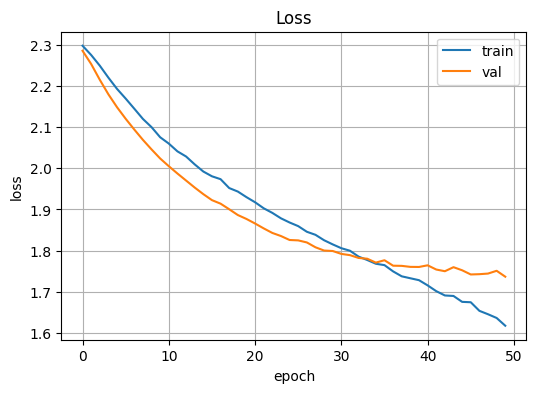

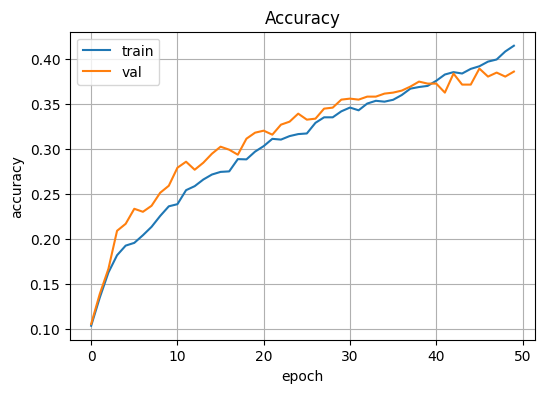

In [14]:
plot_history(history)

##### Evaluation function

In [65]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    preds_list = []
    labels_list = []

    for X, y in loader:
        X = X.to(model.device, non_blocking=True)
        y = y.to(model.device, non_blocking=True)

        logits = model(X)
        # If your criterion uses mean reduction (default), multiply by batch size to sum.
        loss = model.criterion(logits, y)
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        batch_preds = logits.argmax(dim=1)

        total_correct += (batch_preds == y).sum().item()
        total += batch_size

        # Store on CPU to avoid holding graph / GPU memory
        preds_list.append(batch_preds.detach().cpu())
        labels_list.append(y.detach().cpu())

    avg_loss = total_loss / max(total, 1)
    acc = total_correct / max(total, 1)

    # Concatenate into flat tensors for convenience
    preds = torch.cat(preds_list) if preds_list else torch.empty(0, dtype=torch.long)
    labels = torch.cat(labels_list) if labels_list else torch.empty(0, dtype=torch.long)

    return avg_loss, acc, preds, labels


In [67]:
# Evaluate
# _, labels = next(iter(test_loader))
test_loss, test_acc, preds, labels  = evaluate(model,test_loader)
print(f"Testing: Test loss {test_loss: .4f}, Test accuracy: {test_acc: .4f}")

Testing: Test loss  1.7365, Test accuracy:  0.3774


In [80]:
lbls = labels.tolist()

In [81]:
prds = preds.tolist()

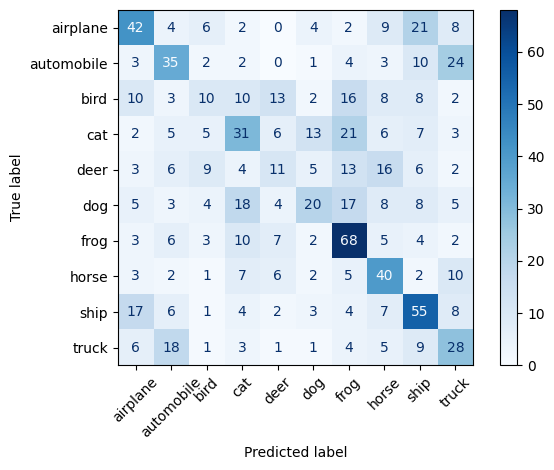

In [86]:
plot_confusion_matrix(lbls, prds, class_names)

The matrix shows uneven class performance: the model is strongest on frog, ship, horse, and airplane, while bird, deer, dog, cat, and truck are much weaker.

# Improving model accuracy

## Adding BatchNormalization

### Model Two

In [89]:
from math import isnan

class DeepMLP2(nn.Module):
    def __init__(self, in_dim, num_classes: int = 10, p_drop: float = 0.3, lr: float = 0.01):
        super().__init__()

        # ---- Training components ----
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self._lr = lr

        # Hidden sizes
        h1, h2, h3, h4 = (1024, 512, 256, 64)

        # Layers
        self.fc1 = nn.Linear(in_dim, h1, bias=False)
        self.bn1 = nn.BatchNorm1d(h1)

        self.fc2 = nn.Linear(h1, h2, bias=False)
        self.bn2 = nn.BatchNorm1d(h2)

        self.fc3 = nn.Linear(h2, h3, bias=False)
        self.bn3 = nn.BatchNorm1d(h3)

        self.fc4 = nn.Linear(h3, h4, bias=False)
        self.bn4 = nn.BatchNorm1d(h4)

        self.out = nn.Linear(h4, num_classes)
        self.drop = nn.Dropout(p_drop)

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = x.flatten(1) if x.dim() > 2 else x
        x = self.fc1(x); x = self.bn1(x); x = F.relu(x); x = self.drop(x)
        x = self.fc2(x); x = self.bn2(x); x = F.relu(x); x = self.drop(x)
        x = self.fc3(x); x = self.bn3(x); x = F.relu(x); x = self.drop(x)
        x = self.fc4(x); x = self.bn4(x); x = F.relu(x)
        logits = self.out(x)
        return logits

    # ---- Helpers ----
    def build_optimizer(self, lr: float | None = None):
        if lr is not None:
            self._lr = lr
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self._lr, momentum=0.9)

    @torch.no_grad()
    def evaluate(self, loader):
        self.eval()
        total_loss, total_correct, total = 0.0, 0, 0
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)
            logits = self(X)
            loss = self.criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += y.size(0)
        avg_loss = total_loss / max(total, 1)
        acc = total_correct / max(total, 1)
        return avg_loss, acc

    @torch.no_grad()
    def predict(self, X):
        self.eval()
        X = X.to(self.device)
        logits = self(X)
        return logits.softmax(dim=1)

    # ---- Training loop ----
    def fit(self, train_loader, val_loader=None, epochs: int = 10, lr: float | None = None, log_every: int = 100):
        if self.optimizer is None or (lr is not None and lr != self._lr):
            self.build_optimizer(lr)

        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for epoch in range(1, epochs + 1):
            self.train()
            running_loss, running_correct, seen = 0.0, 0, 0

            for step, (X, y) in enumerate(train_loader, 1):
                X, y = X.to(self.device), y.to(self.device)

                # Forward
                logits = self(X)
                loss = self.criterion(logits, y)

                # Backward
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Stats
                with torch.no_grad():
                    running_loss += loss.item() * y.size(0)
                    preds = logits.argmax(dim=1)
                    running_correct += (preds == y).sum().item()
                    seen += y.size(0)

                if log_every and step % log_every == 0:
                    print(f"Epoch {epoch}/{epochs}  Step {step}  "
                          f"TrainLoss {(running_loss/seen):.4f}  TrainAcc {(running_correct/seen):.4f}")

            # End-epoch metrics
            train_loss = running_loss / max(seen, 1)
            train_acc = running_correct / max(seen, 1)

            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}  "
                      f"ValLoss {val_loss:.4f} Acc {val_acc:.4f}")
            else:
                val_loss, val_acc = float('nan'), float('nan')
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}")

            # record history once per epoch
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        return history


#### Training

In [90]:
model2 = DeepMLP2(num_classes=10, in_dim=in_dim, lr=0.01)

xb, labels = next(iter(train_loader))

_ = model2(xb.to(model2.device))

# Train
history = model2.fit(train_loader, valid_loader, epochs=50, lr=0.001, log_every=200)


[Epoch 1] TrainLoss 2.3054 Acc 0.1389  ValLoss 2.1483 Acc 0.2478
[Epoch 2] TrainLoss 2.1461 Acc 0.2177  ValLoss 2.0651 Acc 0.2889
[Epoch 3] TrainLoss 2.0740 Acc 0.2465  ValLoss 2.0086 Acc 0.3022
[Epoch 4] TrainLoss 2.0225 Acc 0.2791  ValLoss 1.9655 Acc 0.3022
[Epoch 5] TrainLoss 1.9755 Acc 0.2932  ValLoss 1.9278 Acc 0.3322
[Epoch 6] TrainLoss 1.9276 Acc 0.3145  ValLoss 1.8912 Acc 0.3400
[Epoch 7] TrainLoss 1.9017 Acc 0.3130  ValLoss 1.8577 Acc 0.3456
[Epoch 8] TrainLoss 1.8701 Acc 0.3326  ValLoss 1.8368 Acc 0.3600
[Epoch 9] TrainLoss 1.8386 Acc 0.3437  ValLoss 1.8154 Acc 0.3489
[Epoch 10] TrainLoss 1.8014 Acc 0.3558  ValLoss 1.7910 Acc 0.3600
[Epoch 11] TrainLoss 1.7673 Acc 0.3761  ValLoss 1.7723 Acc 0.3711
[Epoch 12] TrainLoss 1.7481 Acc 0.3755  ValLoss 1.7597 Acc 0.3744
[Epoch 13] TrainLoss 1.7226 Acc 0.3841  ValLoss 1.7454 Acc 0.3756
[Epoch 14] TrainLoss 1.7056 Acc 0.3862  ValLoss 1.7283 Acc 0.3844
[Epoch 15] TrainLoss 1.6770 Acc 0.4019  ValLoss 1.7183 Acc 0.3767
[Epoch 16] TrainLos

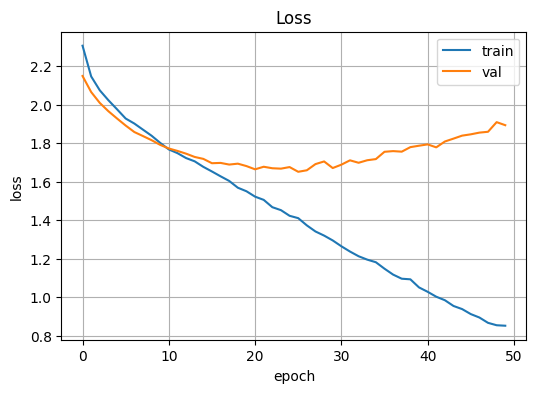

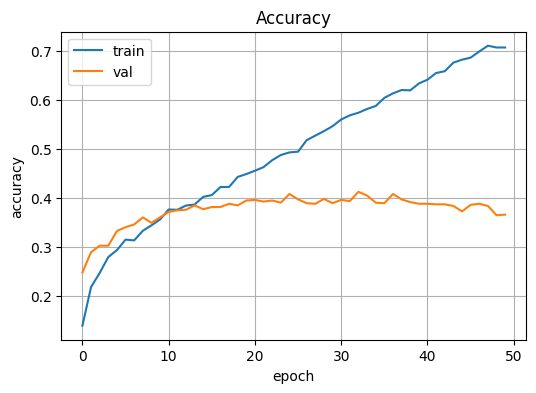

In [91]:
plot_history(history)

Though the model seems to have a good validation accuracy. We can see here that the model isn't performing well on the validation set. The validation loss and accuracy are very far from that of the training dataset. Meaning, the model is performing well on the training dataset but isnt generalizing properly.

In [92]:
# Evaluate
print("Evaluation for the second model architecture")
test_loss, test_acc, preds, labels  = evaluate(model2,test_loader)
print(f"Testing: Test loss {test_loss: .4f}, Test accuracy: {test_acc: .4f}")

Evaluation for the second model architecture
Testing: Test loss  1.9081, Test accuracy:  0.3762


In [93]:
lbls2 = labels.tolist()

In [94]:
prds2 = preds.tolist()

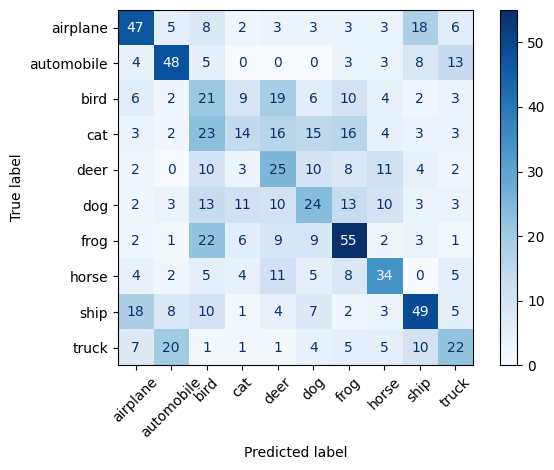

In [95]:
plot_confusion_matrix(lbls2, prds2, class_names)

Though the model is overfitting, it classifies some of the images better than that of the first model. However it has a not so significantly lower accuracy than the first model.

## Increasing number of epochs

##### Will a smaller learning rate and increased epochs improve the model?

In [96]:
model3 = DeepMLP2(num_classes=10, in_dim=in_dim, lr=0.0001)

# First forward pass to initialize LazyLinear input dims
_ = model3(xb.to(model2.device))

# Train
history = model3.fit(train_loader, valid_loader, epochs=100, lr=0.0001, log_every=200)

# Evaluate
test_loss, test_acc = model3.evaluate(test_loader)
print(f"Testing: Test loss {test_loss: .4f}, Test accuracy: {test_acc: .4f}")

[Epoch 1] TrainLoss 2.3625 Acc 0.1104  ValLoss 2.3010 Acc 0.1056
[Epoch 2] TrainLoss 2.3287 Acc 0.1178  ValLoss 2.2729 Acc 0.1289
[Epoch 3] TrainLoss 2.2997 Acc 0.1390  ValLoss 2.2487 Acc 0.1589
[Epoch 4] TrainLoss 2.2795 Acc 0.1518  ValLoss 2.2273 Acc 0.1733
[Epoch 5] TrainLoss 2.2526 Acc 0.1679  ValLoss 2.2088 Acc 0.1756
[Epoch 6] TrainLoss 2.2387 Acc 0.1722  ValLoss 2.1946 Acc 0.1811
[Epoch 7] TrainLoss 2.2208 Acc 0.1784  ValLoss 2.1790 Acc 0.1933
[Epoch 8] TrainLoss 2.2059 Acc 0.1939  ValLoss 2.1680 Acc 0.1956
[Epoch 9] TrainLoss 2.1920 Acc 0.2016  ValLoss 2.1520 Acc 0.2144
[Epoch 10] TrainLoss 2.1816 Acc 0.1986  ValLoss 2.1365 Acc 0.2178
[Epoch 11] TrainLoss 2.1692 Acc 0.2087  ValLoss 2.1244 Acc 0.2278
[Epoch 12] TrainLoss 2.1497 Acc 0.2190  ValLoss 2.1137 Acc 0.2367
[Epoch 13] TrainLoss 2.1375 Acc 0.2298  ValLoss 2.1041 Acc 0.2411
[Epoch 14] TrainLoss 2.1359 Acc 0.2227  ValLoss 2.0925 Acc 0.2500
[Epoch 15] TrainLoss 2.1284 Acc 0.2289  ValLoss 2.0851 Acc 0.2533
[Epoch 16] TrainLos

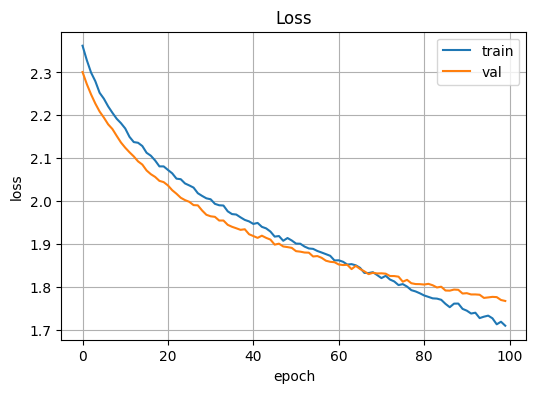

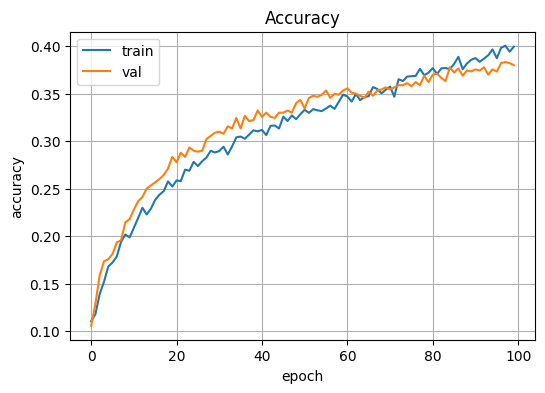

In [97]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.grid(True); plt.legend(); plt.show()

# Accuracy (optional)
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.grid(True); plt.legend(); plt.show()

In [99]:
# Evaluate
print("Evaluation for the third model architecture")
test_loss, test_acc, preds, labels  = evaluate(model3,test_loader)
print(f"Testing: Test loss {test_loss: .4f}, Test accuracy: {test_acc: .4f}")

Evaluation for the third model architecture
Testing: Test loss  1.7645, Test accuracy:  0.3552


In [100]:
lbls3 = labels.tolist()

In [101]:
prds3 = preds.tolist()

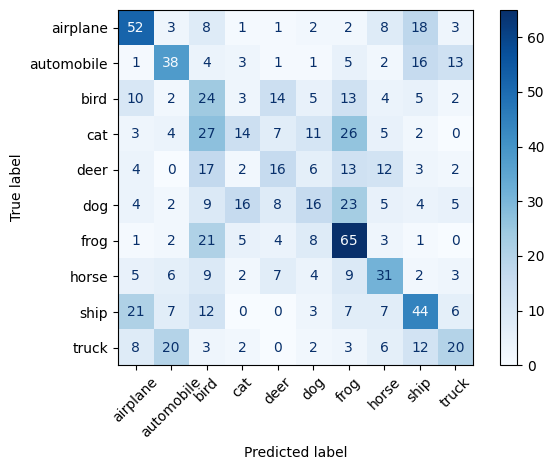

In [103]:
plot_confusion_matrix(lbls3, prds3, class_names)

The test accuracy here is 35.52%. The model did not perform beteer than the model above. However, we see that it is able to categories some images like airplane better than the model above.

# Convolutional Neural Network

In [104]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes: int = 10, p_drop: float = 0.3, lr: float = 0.01):
        super().__init__()

        # ---- Feature extractor (Conv → BN → ReLU) ----
        self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2)
        self.drop2d= nn.Dropout2d(p_drop/2)

        # ---- Classifier head ----
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p_drop)

        # ---- Training components ----
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self._lr = lr

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    # ---- Forward ----
    def forward(self, x):
        # x: (B, C, H, W)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.drop2d(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

    # ---- Optimizer ----
    def build_optimizer(self, lr: float | None = None, weight_decay: float = 1e-4):
        if lr is not None:
            self._lr = lr
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self._lr, weight_decay=weight_decay)
        return self.optimizer

    # ---- Evaluate ----
    @torch.no_grad()
    def evaluate(self, loader):
        self.eval()
        total_loss, total_correct, total = 0.0, 0, 0
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)
            logits = self(X)
            loss   = self.criterion(logits, y)
            bs = y.size(0)
            total_loss   += float(loss) * bs
            total_correct+= int((logits.argmax(1) == y).sum())
            total        += bs
        return total_loss / max(total, 1), total_correct / max(total, 1)

    # ---- Predict probabilities ----
    @torch.no_grad()
    def predict(self, X):
        self.eval()
        X = X.to(self.device)
        return self(X).softmax(dim=1)

    # ---- Train loop (returns history for plotting) ----
    def fit(self, train_loader, val_loader=None, epochs: int = 10, lr: float | None = None, log_every: int = 100):
        self.train()

        # Materialize Lazy layers, then (re)build optimizer
        if self.optimizer is None or (lr is not None and lr != self._lr):
            X_warm, _ = next(iter(train_loader))
            _ = self(X_warm.to(self.device))
            self.build_optimizer(lr)

        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

        for epoch in range(1, epochs + 1):
            self.train()
            running_loss, running_correct, seen = 0.0, 0, 0

            for step, (X, y) in enumerate(train_loader, 1):
                X, y = X.to(self.device), y.to(self.device)

                logits = self(X)
                loss   = self.criterion(logits, y)

                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()

                # stats
                bs = y.size(0)
                running_loss   += float(loss.detach().cpu()) * bs
                running_correct+= int((logits.argmax(1) == y).sum().detach().cpu())
                seen           += bs

                if log_every and step % log_every == 0:
                    print(f"Epoch {epoch}/{epochs} Step {step}/{len(train_loader)} "
                          f"TrainLoss {running_loss/seen:.4f} TrainAcc {running_correct/seen:.4f}")

            # end-of-epoch
            train_loss = running_loss / max(seen, 1)
            train_acc  = running_correct / max(seen, 1)

            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}  "
                      f"ValLoss {val_loss:.4f} Acc {val_acc:.4f}")
            else:
                val_loss, val_acc = None, None
                print(f"[Epoch {epoch}] TrainLoss {train_loss:.4f} Acc {train_acc:.4f}")

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        return history


#### Training

In [ ]:
model4 = DeepCNN(num_classes=10,lr=0.01)

_ = model4(xb.to(model4.device))

# Train
history = model4.fit(train_loader, valid_loader, epochs=50, lr=0.001, log_every=200)

# Evaluate
test_loss, test_acc = model4.evaluate(test_loader)
print(f"Testing: Test loss {test_loss: .4f}, Test accuracy: {test_acc: .4f}")

[Epoch 1] TrainLoss 2.3295 Acc 0.2240  ValLoss 1.8686 Acc 0.3211
[Epoch 2] TrainLoss 1.8452 Acc 0.2988  ValLoss 1.6669 Acc 0.3811
[Epoch 3] TrainLoss 1.7262 Acc 0.3426  ValLoss 1.6081 Acc 0.4122
[Epoch 4] TrainLoss 1.6435 Acc 0.3741  ValLoss 1.5655 Acc 0.4267
[Epoch 5] TrainLoss 1.5821 Acc 0.4034  ValLoss 1.5635 Acc 0.4422
[Epoch 6] TrainLoss 1.4925 Acc 0.4361  ValLoss 1.4804 Acc 0.4456
[Epoch 7] TrainLoss 1.4492 Acc 0.4552  ValLoss 1.4263 Acc 0.4922
[Epoch 8] TrainLoss 1.4142 Acc 0.4715  ValLoss 1.5283 Acc 0.4511
[Epoch 9] TrainLoss 1.3659 Acc 0.4899  ValLoss 1.3915 Acc 0.4967
[Epoch 10] TrainLoss 1.3036 Acc 0.5162  ValLoss 1.4518 Acc 0.4811
[Epoch 11] TrainLoss 1.2622 Acc 0.5230  ValLoss 1.3282 Acc 0.5133
[Epoch 12] TrainLoss 1.2087 Acc 0.5466  ValLoss 1.2977 Acc 0.5533
[Epoch 13] TrainLoss 1.1784 Acc 0.5491  ValLoss 1.5383 Acc 0.4744
[Epoch 14] TrainLoss 1.1539 Acc 0.5659  ValLoss 1.3958 Acc 0.5344
[Epoch 15] TrainLoss 1.1038 Acc 0.5821  ValLoss 1.5464 Acc 0.4767
[Epoch 16] TrainLos

In [ ]:
plot_history(history)

The difference between the training acuracy and validation accuracy is quite huge. This suggests that the model is overfitting.